In [1]:
from os import listdir
from os.path import isfile, join
import sys
import copy
import re
import numpy as np

from scipy.signal import stft
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm
from utils import Person, simple_low_pass, exp_feat, window_spikes, analyze, do_tc_full
import pickle as pkl
import peakutils
import pywt

from jAER_utils.converter import aedat2numpy
from utils import analyze

import pandas as pd
import seaborn as sns
import cv2

In [2]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']

Load all data into subject obects 

In [3]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
    
    subjects[name.split("_")[1]] = Person(name.split("_")[1], _emg, _ann, classes=classes)
    
    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format(name.split("_")[1], _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

Loaded Charlotte1: EMG = [(25315, 8)] // ANN = [25315]
Loaded Simone3: EMG = [(25324, 8)] // ANN = [25324]
Loaded Enea3: EMG = [(25242, 8)] // ANN = [25242]
Loaded Marcus1: EMG = [(25294, 8)] // ANN = [25294]
Loaded Gemma1: EMG = [(24993, 8)] // ANN = [24993]
Loaded Bruno2: EMG = [(25331, 8)] // ANN = [25331]
Loaded Erika3: EMG = [(25332, 8)] // ANN = [25332]
Loaded Lyes3: EMG = [(25240, 8)] // ANN = [25240]
Loaded Baris3: EMG = [(25244, 8)] // ANN = [25244]
Loaded Simone2: EMG = [(25318, 8)] // ANN = [25318]
Loaded Bruno3: EMG = [(25318, 8)] // ANN = [25318]
Loaded Enea2: EMG = [(25328, 8)] // ANN = [25328]
Loaded Erika2: EMG = [(25330, 8)] // ANN = [25330]
Loaded Lyes2: EMG = [(25304, 8)] // ANN = [25304]
Loaded Baris2: EMG = [(25089, 8)] // ANN = [25089]
Loaded Melika1: EMG = [(25140, 8)] // ANN = [25140]
Loaded Gemma3: EMG = [(24903, 8)] // ANN = [24903]
Loaded Marcus3: EMG = [(25328, 8)] // ANN = [25328]
Loaded Enea1: EMG = [(25315, 8)] // ANN = [25315]
Loaded Simone1: EMG = [(253

In [4]:
# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Done sorting trials!


Now every subject has different fields, each field is a dictionary and the keys are the gestures.
We have the following fields: begs (beginning time of trials), ends (end time of trials), trials (actual myo data)

In [5]:
# example, see that each gesture is 2 seconds
print(np.array(subjects['Gemma1'].begs['elle']) / fs)
print(np.array(subjects['Gemma1'].ends['elle']) / fs)

[  7.575  31.98   56.73   81.275 106.02 ]
[  9.515  33.95   58.73   83.265 108.02 ]


In [6]:
# this is to find the zero timestepping of the davis
def find_trigger(ts):
    return np.where(np.diff(ts) < 0)[0][0]

def create_frame(x, y, dim=(128, 128)):
    img = np.zeros(dim)
    for _x, _y in zip(x.astype('int32'), y.astype('int32')):
        img[dim[0] - 1 - _x,_y] += 1
    return np.log10(img / np.max(img) + 1e-10)

In [7]:
subject = 'Bruno2'
# decoders takes some time since it is a very long recordings, especially with DAVIS
events = aedat2numpy(data_dir + subject +'_dvs.aedat')
events = events[:, find_trigger(events[2]):]
events[2] = events[2] / 1e3
print(events.shape)

(4, 3359047)


(4, 20773)


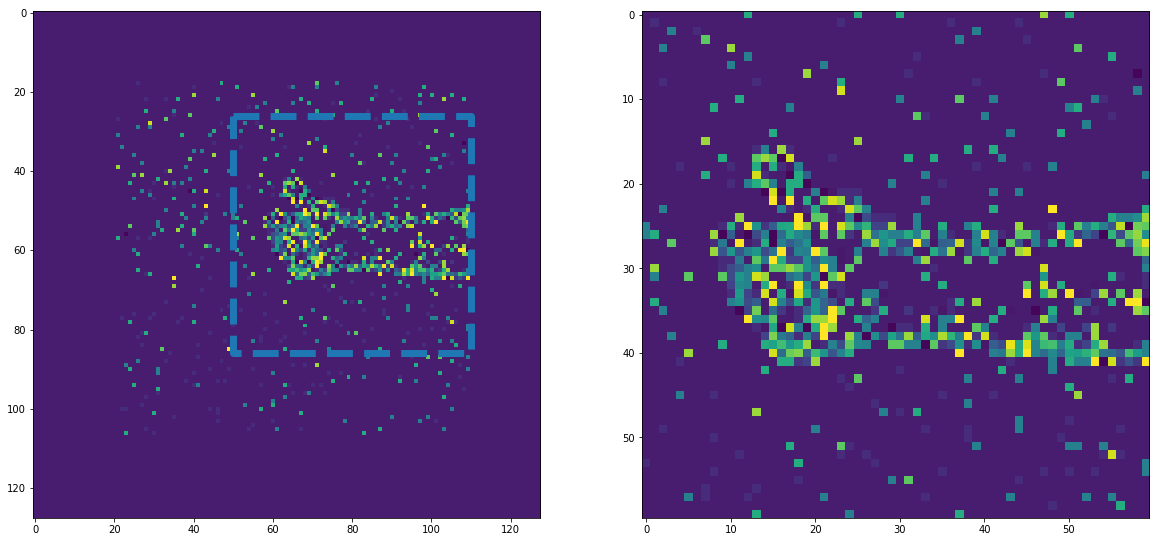

In [8]:
gesture = 'thumb'
trial = 3
# load beginning and end 
b = np.array(subjects[subject].begs[gesture][trial]) / fs
e = np.array(subjects[subject].ends[gesture][trial]) / fs

frame_size = 1.
shift = 1.
beginning = b + shift
ending = beginning + frame_size
# slice
sl = (events[2] > beginning) & (events[2] < ending)

img = events[:, sl]
print(img.shape)
fig, ax = plt.subplots(1, 2, figsize=(20,10))

beg_int = int(shift * fs)
end_int = int((shift + frame_size) * fs)

# dd = subjects[subject].trials[gesture][trial][beg_int:end_int]
# feat = analyze(dd, frame_len=0.01, frame_step=0.005, feat='RMS')
# for i in range(8):
#     _ = ax[1].plot(dd[:, i], label='channel{}'.format(i))
# ax[1].legend()

sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

M = cv2.moments(thresh)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

_ = ax[0].imshow(frame)
ax[0].plot([x - 30, x + 30, x + 30, x - 30, x - 30], 
           [y  - 30, y  - 30, y + 30, y  + 30, y  - 30], '--', linewidth=7)

_ = ax[1].imshow(frame[y - 30: y + 30, x-30:x+30])



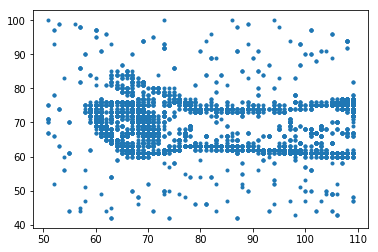

In [9]:
a = (img[0] > (x - 30)) & (img[0] < (x + 30))
b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
xx = img[0][a & b]
yy = img[1][a & b]
ts = img[2][a & b]
pol = img[3][a & b]

plt.plot(xx, yy, '.')

In [10]:
for subject, data in subjects.items():

    # decoders takes some time since it is a very long recordings, especially with DAVIS
    events = aedat2numpy(data_dir + subject +'_dvs.aedat')
    events = events[:, find_trigger(events[2]):]
    events[2] = events[2] / 1e3
    
    for gesture in classes:
        for trial in range(5):
            print("{} :: {} :: {}".format(subject, gesture, trial))
            # load beginning and end 
            b = np.array(data.begs[gesture][trial]) / fs
            e = np.array(data.ends[gesture][trial]) / fs

            frame_size = 2
            shift = 0.
            beginning = b + shift
            ending = beginning + frame_size

            # slice
            sl = (events[2] > beginning) & (events[2] < ending)

            img = events[:, sl]

            beg_int = int(shift * fs)
            end_int = int((shift + frame_size) * fs)

            sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

            frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
            blurred = cv2.GaussianBlur(frame, (5, 5), 0)
            thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            M = cv2.moments(thresh)
            x = int(M["m10"] / M["m00"])
            y = int(M["m01"] / M["m00"])

            a = (img[0] > (x - 30)) & (img[0] < (x + 30))
            b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
            xx = img[0][a & b]
            yy = img[1][a & b]
            ts = img[2][a & b]
            pol = img[3][a & b]

            data.x[gesture].append(xx - min(xx))
            data.y[gesture].append(yy - min(yy))
            data.ts[gesture].append(ts - min(ts))
            data.pol[gesture].append(pol)


Charlotte1 :: pinky :: 0
Charlotte1 :: pinky :: 1
Charlotte1 :: pinky :: 2
Charlotte1 :: pinky :: 3
Charlotte1 :: pinky :: 4
Charlotte1 :: elle :: 0
Charlotte1 :: elle :: 1
Charlotte1 :: elle :: 2
Charlotte1 :: elle :: 3
Charlotte1 :: elle :: 4
Charlotte1 :: yo :: 0
Charlotte1 :: yo :: 1
Charlotte1 :: yo :: 2
Charlotte1 :: yo :: 3
Charlotte1 :: yo :: 4
Charlotte1 :: index :: 0
Charlotte1 :: index :: 1
Charlotte1 :: index :: 2
Charlotte1 :: index :: 3
Charlotte1 :: index :: 4
Charlotte1 :: thumb :: 0
Charlotte1 :: thumb :: 1
Charlotte1 :: thumb :: 2
Charlotte1 :: thumb :: 3
Charlotte1 :: thumb :: 4
Simone3 :: pinky :: 0
Simone3 :: pinky :: 1
Simone3 :: pinky :: 2
Simone3 :: pinky :: 3
Simone3 :: pinky :: 4
Simone3 :: elle :: 0
Simone3 :: elle :: 1
Simone3 :: elle :: 2
Simone3 :: elle :: 3
Simone3 :: elle :: 4
Simone3 :: yo :: 0
Simone3 :: yo :: 1
Simone3 :: yo :: 2
Simone3 :: yo :: 3
Simone3 :: yo :: 4
Simone3 :: index :: 0
Simone3 :: index :: 1
Simone3 :: index :: 2
Simone3 :: index ::

Gemma3 :: pinky :: 2
Gemma3 :: pinky :: 3
Gemma3 :: pinky :: 4
Gemma3 :: elle :: 0
Gemma3 :: elle :: 1
Gemma3 :: elle :: 2
Gemma3 :: elle :: 3
Gemma3 :: elle :: 4
Gemma3 :: yo :: 0
Gemma3 :: yo :: 1
Gemma3 :: yo :: 2
Gemma3 :: yo :: 3
Gemma3 :: yo :: 4
Gemma3 :: index :: 0
Gemma3 :: index :: 1
Gemma3 :: index :: 2
Gemma3 :: index :: 3
Gemma3 :: index :: 4
Gemma3 :: thumb :: 0
Gemma3 :: thumb :: 1
Gemma3 :: thumb :: 2
Gemma3 :: thumb :: 3
Gemma3 :: thumb :: 4
Marcus3 :: pinky :: 0
Marcus3 :: pinky :: 1
Marcus3 :: pinky :: 2
Marcus3 :: pinky :: 3
Marcus3 :: pinky :: 4
Marcus3 :: elle :: 0
Marcus3 :: elle :: 1
Marcus3 :: elle :: 2
Marcus3 :: elle :: 3
Marcus3 :: elle :: 4
Marcus3 :: yo :: 0
Marcus3 :: yo :: 1
Marcus3 :: yo :: 2
Marcus3 :: yo :: 3
Marcus3 :: yo :: 4
Marcus3 :: index :: 0
Marcus3 :: index :: 1
Marcus3 :: index :: 2
Marcus3 :: index :: 3
Marcus3 :: index :: 4
Marcus3 :: thumb :: 0
Marcus3 :: thumb :: 1
Marcus3 :: thumb :: 2
Marcus3 :: thumb :: 3
Marcus3 :: thumb :: 4
Enea1 :

In [11]:
import pickle as pkl
pkl.dump(subjects, open('10_people_dvs_emg.pkl', 'wb'))

In [12]:
data = pkl.load(open('10_people_dvs_emg.pkl', 'rb'))

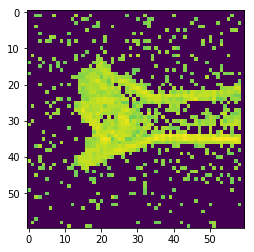

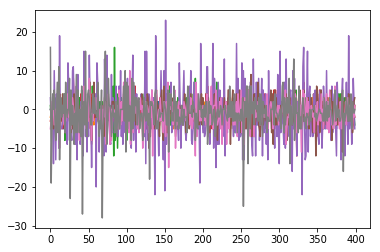

In [16]:
sub = 'Bruno2'
trial = 4
gesture = 'yo'
frame = create_frame(data[sub].y[gesture][trial], data[sub].x[gesture][trial], (60, 60))
plt.imshow(frame)
plt.figure()
plt.plot(data[sub].trials[gesture][trial])

In [ ]:
small_frame = frame#[y - 30: y + 30, x-30:x+30]
gray = np.int32(small_frame * 254)

brisk = cv2.BRISK_create()
(kps, descs) = brisk.detectAndCompute(gray, None)
print(kps)

In [ ]:
import cv2
import imutils

frame = np.uint8(create_frame(img[1], img[0]) * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

M = cv2.moments(thresh)
print(M)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX)
print(cY)

plt.imshow(frame, aspect='auto')
plt.plot(cX, cY, 'ro')


In [ ]:
import csv
with open('gesture.csv', 'w') as f:
    csv_writer = csv.writer(f, delimiter=',')
    csv_writer.writerow(['x', 'y', 'type'])
    for i in range(img.shape[1]):
        csv_writer.writerow([img[0, i], img[1, i], img[3, i]])


In [ ]:
data = pd.read_csv('gesture.csv')

g = sns.jointplot("x", "y", data=data, size=20)
plt.savefig('spatial_density_yo.pdf')

In [ ]:
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
gm = GaussianMixture(4) 
gm.fit(img[0].reshape(-1, 1) / 180)

x = np.linspace(0, 1, 1000)
plt.hist(img[0] / 180, 50, density=True)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[0], gm.covariances_[0]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[1], gm.covariances_[1]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[2], gm.covariances_[2]).T)

